In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gzip
import os
import itertools

import seaborn as sns
import scipy

Model:

$ \tau dx_i = dt\left((1-\alpha) Sun(t)+\frac{\alpha}{N} \sum_i (x_i\geq \eta_i) - x_i\right) + \sigma dW(t) $


## Simulation functions

In [4]:
        
def runsim(numbees,
           sunamplitude,
           sigma, # noise amplitude
           alpha, # social weight
           eta_std, # threshold std dev
           eta_mean = 0.5,
           seedrand=False  # for repeatable results - this was used for the main model results figures
          ):
    tau=15
    totaltime=12*60
    dt=0.1
    numsteps=np.round(totaltime/dt).astype(int)
    
    sun = sunamplitude*np.sin(np.arange(numsteps)*dt * 2*np.pi/totaltime/2)
    if seedrand:
        np.random.seed(5)
    etavals = eta_mean + np.random.standard_normal(numbees)*eta_std
    allx = np.zeros((numsteps,numbees))
    tpx_hours = np.arange(numsteps)*dt/60

    for step in range(1,numsteps):
        prev = allx[step-1]
        allx[step]=(prev + dt/tau*((1-alpha)*sun[step]+alpha/numbees*np.sum(prev>etavals)-prev)
                    + sigma*np.sqrt(dt)*np.random.standard_normal(numbees)/tau)
    return allx, tpx_hours, sun, etavals

## Run single simulation

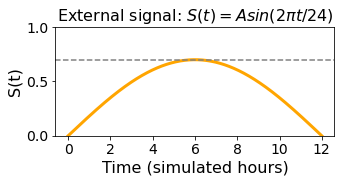

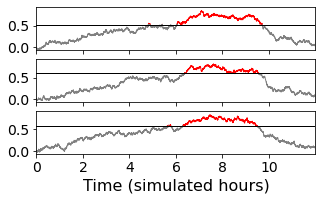

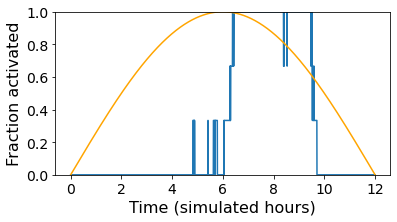

In [6]:

sunamplitude=0.7

numbees=3
sigma = 0.25  # noise amplitude
alpha = 0.3 # social weight
eta_std = 0.1

allx, tpx_hours, sun, etavals = runsim(numbees,sunamplitude,sigma,alpha,eta_std)


# show sun and threshold params
f,ax = plt.subplots(1,1)
f.set_size_inches(5,2)
a=ax
a.plot(tpx_hours,sun,c='orange',linestyle='-',linewidth=3)
a.set_ylim([0,1])
a.set_ylabel('S(t)',fontsize=16)
a.set_title('External signal: $S(t)=A sin(2\pi t/24)$',fontsize=16)
a.axhline(sunamplitude,c='gray',linestyle='--')
a.set_xlabel('Time (simulated hours)',fontsize=16)
a.tick_params(labelsize=14)
a.set_xticks(np.arange(0,13,2))
plt.savefig('image-output/example-p1.pdf')
plt.show()

f,ax=plt.subplots(numbees,1,sharex=True,sharey=True)
f.set_size_inches(5,0.9*numbees)
for i in range(numbees):
    a=ax[i]
    tp = allx[:,i].copy()
    threshold = etavals[i]
    tpact = tp.copy()
    tpnonact = tp.copy()
    tpact[tp<threshold]=np.nan
    tpnonact[tp>=threshold]=np.nan
    a.plot(tpx_hours,tpact,linewidth=1,c='r')
    a.plot(tpx_hours,tpnonact,linewidth=1,c='grey')    
    a.axhline(threshold,c='k',linewidth=1)
    a.set_xlim([0,np.max(tpx_hours)])
    a.tick_params(labelsize=14)
a.set_ylim([np.min(allx),np.max(allx)*1.1])    
ax[-1].set_xlabel('Time (simulated hours)',fontsize=16)
plt.savefig('image-output/example-p2.pdf')
plt.show()

f,ax=plt.subplots(1,1)
f.set_size_inches(6,3)
a=ax
a.plot(tpx_hours,np.mean((allx>etavals),axis=1))
a.plot(tpx_hours,sun/sunamplitude,c='orange')
a.set_ylabel('Fraction activated',fontsize=16)
a.set_ylim([0,1])
a.tick_params(labelsize=14)
a.set_xlabel('Time (simulated hours)',fontsize=16)

plt.show()

## Run multiple values and make grid plots

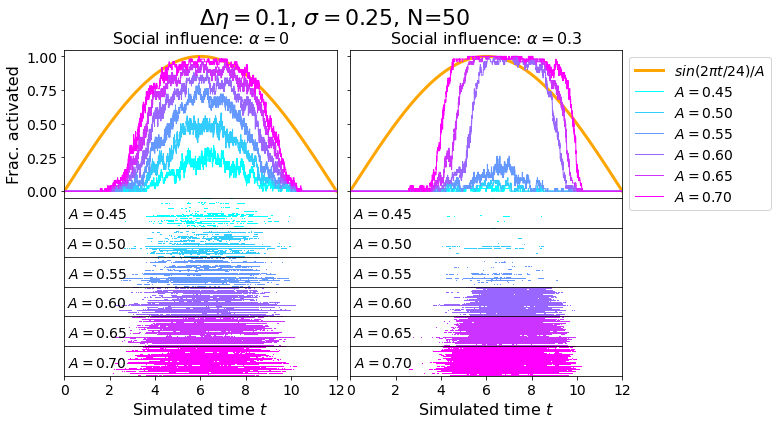

In [151]:
numbees=50
sigma = 0.25  # noise amplitude
eta_std = 0.1

alphavals = [0,0.3]
sunamps = (np.arange(0.45,0.701,0.05))

for sigma in [0,0.25]:
    for eta_std in [0,0.1]:
        None
        
sigma=0.25
eta_std = 0.1

cmapsun = plt.get_cmap('cool') #'cool'
from matplotlib.colors import LinearSegmentedColormap

f,ax=plt.subplots(len(sunamps)+1,len(alphavals),sharey='row',
                  gridspec_kw=dict(height_ratios=np.insert(np.tile(0.2,len(sunamps)),0,1)))
f.set_size_inches(5*len(alphavals),3+0.5*len(sunamps))
for j,alpha in enumerate(alphavals):
    for i,sunamplitude in enumerate(sunamps):
        allx, tpx_hours, sun, etavals = runsim(numbees,sunamplitude,sigma,alpha,eta_std,seedrand=True)
        a=ax[0,j]
        if i==0:
            a.plot(tpx_hours,sun/sunamplitude,c='orange',label='$sin(2\pi t/24)/A$',linestyle='-',linewidth=3)
            a.set_title('Social influence: $\\alpha='+str(alpha)+'$',fontsize=16)
        amplabel ='$A='+('{:03.2f}'.format(sunamplitude))+'$'
        clr = cmapsun( (sunamplitude-np.min(sunamps))/(np.max(sunamps)-np.min(sunamps)) )
        a.plot(tpx_hours,np.mean((allx>etavals),axis=1),c=clr,label=amplabel,linewidth=1) 
        a=ax[i+1,j]
        cm = LinearSegmentedColormap.from_list("",[(1,1,1),clr[0:3]], N=2)
        a.pcolormesh(tpx_hours,np.arange(numbees),(allx>etavals).T,rasterized=True,cmap=cm)
        a.set_yticks([])
        a.set_ylabel(amplabel,fontsize=14,rotation=0,labelpad=-33,y=0.2,zorder=1)
        a.tick_params(labelsize=14)

a=ax[0,0]
a.set_ylabel('Frac. activated',fontsize=16)
a.tick_params(labelsize=14)

for a in ax[0:-1].flatten():
    a.set_xlim([tpx_hours[0],np.round(tpx_hours[-1])])
    a.set_xticks([])
for a in ax[-1]:
    a.set_xticks(np.arange(0,12.1,2))
    a.set_xlabel('Simulated time $t$',fontsize=16)
ax[0,-1].legend(fontsize=14,bbox_to_anchor=(1,1))

plt.subplots_adjust(hspace=0,wspace=0.05)
plt.suptitle('$\Delta\eta='+str(eta_std)+'$, $\sigma='+str(sigma)+'$, N='+str(numbees),fontsize=22)
plt.savefig('image-output/rastersim.pdf')
plt.show()

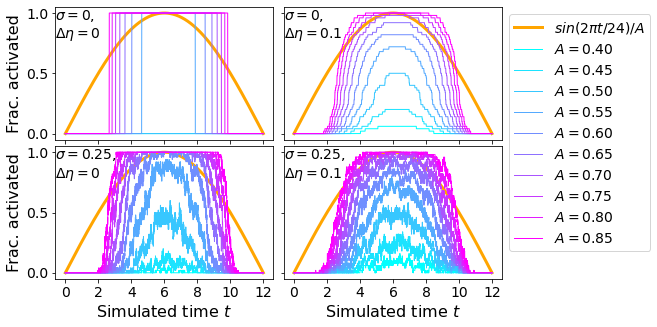

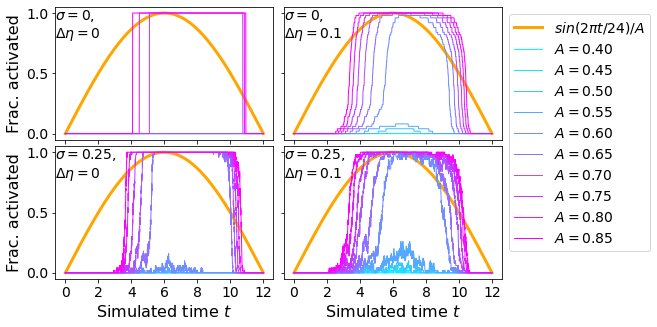

In [150]:
numbees=50
sigma = 0.25  # noise amplitude
eta_std = 0.1

cmapsun = plt.get_cmap('cool') #'cool'
from matplotlib.colors import LinearSegmentedColormap

alpha = 0.3
for alpha in [0,0.3]:
    sunamps = np.arange(0.4,0.851,0.05)
    sigmavals = [0,0.25]
    eta_stdvals = [0,0.1]

    f,ax=plt.subplots(len(sigmavals),len(eta_stdvals),sharey=True,sharex=True)
    f.set_size_inches(4*ax.shape[1],2.5*ax.shape[0])

    for i,sigma in enumerate(sigmavals):
        for j,eta_std in enumerate(eta_stdvals):
            a=ax[i,j]
            a.set_title('$\sigma='+str(sigma)+'$,\n'+'$\Delta\eta='+str(eta_std)+'$',fontsize=14,y=0.72,loc='left')
            a.tick_params(labelsize=14)

            for s,sunamplitude in enumerate((sunamps)):
                allx, tpx_hours, sun, etavals = runsim(numbees,sunamplitude,sigma,alpha,eta_std,seedrand=True)
                if s==0:
                    a.plot(tpx_hours,sun/sunamplitude,c='orange',label='$sin(2\pi t/24)/A$',linestyle='-',linewidth=3)
                amplabel ='$A='+('{:03.2f}'.format(sunamplitude))+'$'
                clr = cmapsun( (sunamplitude-np.min(sunamps))/(np.max(sunamps)-np.min(sunamps)) )
                a.plot(tpx_hours,np.mean((allx>etavals),axis=1),c=clr,label=amplabel,linewidth=1) 


    for a in ax[:,0]:
        a.set_ylabel('Frac. activated',fontsize=16)

    for a in ax[-1]:
        a.set_xticks(np.arange(0,12.1,2))
        a.set_xlabel('Simulated time $t$',fontsize=16)
    ax[0,-1].legend(fontsize=14,bbox_to_anchor=(1,1))

    plt.subplots_adjust(hspace=0.05,wspace=0.05)
    plt.savefig('image-output/simgrid-'+str(alpha)+'.pdf')
    plt.show()